Here, we implement Wasserstein regression using PyTorch. We use PyTorch so that we can utilize the AutoGrad framework to calculate gradients since I do not know a closed-form solution for Wasserstein regression similar to scalar linear regression.

If this does not work since some of the operations do not let the gradients pass through such as `torch.unique` or `torch.searchsorted`, we will use SPSA to estimate the gradients.

In [304]:
import torch # will use for AutoGrad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
torch.cat([torch.tensor(0).reshape(1), torch.diff(torch.tensor([1,2,3,4,5]))])

tensor([0, 1, 1, 1, 1])

In [380]:
def empirical_quantile_function(samples):
    """
    Returns a function that computes the empirical quantile function for the given 1D samples.

    Args:
        samples (torch.Tensor): A 1D tensor of samples from a distribution. Assumes is sorted.

    Returns:
        function: A function that takes a tensor of quantiles (q) and returns the corresponding quantile values.
    """
    samples_diff = torch.cat([samples[0].reshape(1), torch.diff(samples)])
    def quantile_function(q):
        """
        Computes the empirical quantile for the given quantiles.

        Args:
            q (torch.Tensor): A tensor of quantiles (values between 0 and 1).

        Returns:
            torch.Tensor: The corresponding quantile values.
        """
        # Compute the empirical CDF values
        n = len(samples)
        cdf = torch.arange(1, n + 1, dtype=torch.float32) / n
        # Use broadcasting to calculate the Heaviside contributions
        heaviside_matrix = torch.heaviside(q.unsqueeze(1) - cdf.unsqueeze(0), torch.tensor(0.0))
        # Add a column of ones to the left of the Heaviside matrix
        first_col = torch.ones(heaviside_matrix.shape[0]).reshape(-1, 1)
        heaviside_matrix = torch.cat([first_col, heaviside_matrix], dim=1)
        # Remove the last column of Heaviside_matrix
        heaviside_matrix = heaviside_matrix[:, :-1]
        # Compute quantile values by summing contributions
        quantile_values = (heaviside_matrix @ samples_diff)

        return quantile_values
    return quantile_function

# Example usage
samples = torch.tensor([1.0, 2.0]).requires_grad_(True)
quantile_fn = empirical_quantile_function(samples)
quantiles = torch.tensor([0.1, 0.5, 1.0])
result = quantile_fn(quantiles)
result

tensor([1., 1., 2.], grad_fn=<MvBackward0>)

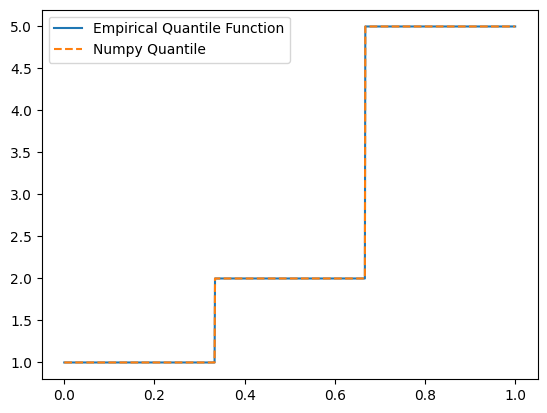

In [410]:
samples = torch.tensor([1.0, 2.0, 5.0])
q_func = empirical_quantile_function(samples)
x = torch.linspace(0,1,1000)

# quantiles_torch = torch.quantile(samples, x, interpolation='midpoint')
quantiles_npy = np.quantile(samples.numpy(), x.numpy(), interpolation='inverted_cdf')
y = q_func(x)

plt.figure()
x_npy = x.numpy()
plt.plot(x_npy, y.detach().numpy())
# plt.plot(x_npy, quantiles_torch.detach().numpy())
plt.plot(x_npy, quantiles_npy, linestyle='--')
plt.legend(['Empirical Quantile Function', 'Numpy Quantile'])

In [411]:
def step_function(x_points, y_points, x):
    # Find the interval that x falls into
    idx = torch.searchsorted(x_points, x, right = True) - 1
    # If x is before the first point, return the first y
    if idx < 0:
        return y_points[0]
    # If x is beyond the last point, return the last y
    elif idx >= len(y_points):
        return y_points[-1]
    # Otherwise, return the y corresponding to the interval
    return y_points[idx]

val = step_function(x,y, 0.5)
val

tensor(2.)

In [57]:
val.backward()

In [426]:
def squared_difference_integral(quantile_func1, quantile_func2, N = 1000):
    quantiles = torch.linspace(0,1,N)
    return torch.sum((quantile_func1(quantiles) - quantile_func2(quantiles)) ** 2) / N

# Example usage
samples1 = torch.tensor([1.0, 2.0]).requires_grad_(True)
samples2 = torch.tensor([2.0, 3.0]).requires_grad_(True)

q1 = empirical_quantile_function(samples1)
q2 = empirical_quantile_function(samples2)

W2 = squared_difference_integral(q1, q2)
W2

tensor(1., grad_fn=<DivBackward0>)

In [713]:
def linear_combination(quantile_fns, weights):
    def lin_comb_fn(q):
        # Compute the quantile values for each function
        quantile_values = torch.stack([fn(q) for fn in quantile_fns])
        # Compute the weighted sum of quantile values
        lin_comb_values = torch.sum(weights.unsqueeze(1) * quantile_values, dim=0)

        return lin_comb_values

    return lin_comb_fn

def barycenter_threshold(quantile_fns, threshold, distances):
    if len(quantile_fns) != len(distances):
        raise ValueError("The number of quantile functions must match the number of distances.")
    quantile_fns = [fn for (fn,dist) in zip(quantile_fns, distances) if dist <= threshold]
    print(len(quantile_fns))
    if len(quantile_fns) == 0:
        raise ValueError("All distances are greater than the threshold.")
    weights = torch.tensor([1/len(quantile_fns)] * len(quantile_fns))
    return linear_combination(quantile_fns, weights)

def barycenter_threshold_soft(quantile_fns, threshold, distances, sharpness=100):
    if len(quantile_fns) != len(distances):
        raise ValueError("The number of quantile functions must match the number of distances.")
    x = torch.sigmoid((threshold - distances) * sharpness)
    weights = x / torch.sum(x)
    return linear_combination(quantile_fns, weights)

# Example usage
samples1 = torch.tensor([1.0, 2.0]).requires_grad_(True)
samples2 = torch.tensor([2.0, 3.0]).requires_grad_(True)
samples3 = torch.tensor([3.0, 4.0]).requires_grad_(True)

q1 = empirical_quantile_function(samples1)
q2 = empirical_quantile_function(samples2)
q3 = empirical_quantile_function(samples3)

quantile_fns = [q1, q2, q3]
weights = torch.tensor([1/3, 1/3, 1/3])
lin_comb_fn = linear_combination(quantile_fns, weights)

quantiles = torch.tensor([0.1, 0.5, 1.0])
print(lin_comb_fn(quantiles))

barycenter_fn = barycenter_threshold(quantile_fns, 1.0, torch.tensor([0.5, 0.9, 1.5]))
print(barycenter_fn(quantiles))

barycenter_fn_soft = barycenter_threshold_soft(quantile_fns, 1.0, torch.tensor([0.5, 0.9, 1.5]), sharpness=100)
print(barycenter_fn_soft(quantiles))

tensor([2., 2., 3.], grad_fn=<SumBackward1>)
2
tensor([1.5000, 1.5000, 2.5000], grad_fn=<SumBackward1>)
tensor([1.5000, 1.5000, 2.5000], grad_fn=<SumBackward1>)


In [415]:
x = torch.linspace(0, 1, 100)
samples = torch.tensor([1.0, 2.0, 5.0]).requires_grad_(True)
q = torch.quantile(samples, x, interpolation='higher')
q

tensor([1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5.], grad_fn=<SqueezeBackward4>)

In [416]:
def expectation(quantile_func, N = 1000):
    x = torch.linspace(0, 1, N)
    quantiles = quantile_func(x)
    return torch.trapezoid(quantiles, x=x)

samples = torch.tensor([1.0, 2.0, 5.0]).requires_grad_(True)
q_func = empirical_quantile_function(samples)

E = expectation(q_func)
print(E)
print(torch.mean(samples))

tensor(2.6647, grad_fn=<DivBackward1>)
tensor(2.6667, grad_fn=<MeanBackward0>)


In [383]:
E.backward()

We should be ready now to implement the Wasserstein regression for the WRDS dataset.

In [146]:
torch.norm(torch.tensor([1.0,2.0,3.0]), p = 1)

tensor(6.)

In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import scipy as sp

In [155]:
with open('quarterly_actual.pkl', 'rb') as f:
    quarterly_actual = pickle.load(f)
    
with open('quarterly_data.pkl', 'rb') as f:
    quarterly_data = pickle.load(f)
    
with open('ibes_tickers.pkl', 'rb') as f:
    ibes_tickers = pickle.load(f)

In [384]:
quarterly_data['AAPL', 2024, 1].head()

,value,ann_datetime
622,2.040,2023-11-02 20:51:00
623,2.084,2023-11-02 22:00:00
624,2.120,2023-11-02 23:10:00
625,2.080,2023-11-02 22:54:00
626,2.080,2023-11-02 23:04:00


Let's optimize for AAPL for 1 column: 2024 Q1

In [173]:
import torch.optim as optim

In [606]:
year = 2023
quarters = [1,2,3,4]
ticker = 'MSFT'

quantile_funcs = dict()
tickers_used_list = []
for quarter in quarters:
    actual_eps, actual_date, actual_time = quarterly_actual[ticker, year, quarter]
    actual_datetime = pd.to_datetime(actual_date + ' ' + actual_time, format = '%Y-%m-%d %H:%M:%S')
    tickers_used = set()
    for oftic,_ in ibes_tickers:
        data = quarterly_data[oftic, year, quarter]
        if data is None:
            continue
        data = data[data['ann_datetime'] < actual_datetime]
        if len(data) == 0:
            continue
        quantile_funcs[oftic, year, quarter] = empirical_quantile_function(torch.tensor(data['value'].sort_values().values).float())
        tickers_used.add(oftic)
    tickers_used_list.append(tickers_used)

tickers_intersection = set.intersection(*tickers_used_list)

delete_keys = []
for key in quantile_funcs:
    if key[0] not in tickers_intersection:
        delete_keys.append(key)
for key in delete_keys:
    del quantile_funcs[key]

weights = torch.tensor([1/len(tickers_intersection) for _ in tickers_intersection], requires_grad = True)

# Optimize weights
optimizer = optim.Adam([weights], lr = 0.01)

In [592]:
l1_hyper = 0
# l2_hyper = 10.0
with tqdm(range(200)) as tepoch:
    for i in tepoch:
        optimizer.zero_grad()
        loss = torch.tensor(0.0)
        for quarter in [1,2,3]: # leave out Q4
            barycenter_fn = linear_combination([quantile_funcs[oftic,year,quarter] for oftic in tickers_intersection], weights)
            mean = expectation(barycenter_fn)
            l1_loss = l1_hyper * torch.norm(weights, p = 1)
            # l2_loss = l2_hyper * (weights @ weights)
            loss += ((mean - actual_eps) ** 2) + l1_loss
        # loss = (torch.abs((mean - actual_eps)) / actual_eps)
        # loss = (mean - actual_eps) ** 2
        loss.backward()
        optimizer.step()
        
        tepoch.set_postfix(loss=loss.item())

100%|██████████| 200/200 [00:14<00:00, 13.88it/s, loss=6.03e-8] 


For estimation using multiple columns, we will need to check for missing data in each column and remove any rows with missing data across all columns to ensure that the weights make sense.

In [494]:
def get_rows_cols():
    cols = [(year, quarter) for year in range(2020, 2025) for quarter in range(1, 5)]
    rows = [t[0] for t in ibes_tickers]
    return rows, cols

rows, cols = get_rows_cols()

train_cols = cols[:len(cols) // 2]
test_col = cols[len(cols) // 2]

In [593]:
with torch.no_grad():
    for quarter in quarters:
        barycenter_fn = linear_combination([quantile_funcs[oftic,year,quarter] for oftic in tickers_intersection], weights)
        mean = expectation(barycenter_fn)
        print(f'Quarter {quarter}')
        print(f'Actual EPS:   {actual_eps}')
        print(f'DistNN EPS:   {mean}')
        baseline_eps = quarterly_data[ticker, year, quarter]["value"].mean()
        print(f'Baseline EPS: {baseline_eps}')
        print(f'DistNN Relative Error:   {np.abs(mean - actual_eps) / actual_eps}')
        print(f'Baseline Relative Error: {np.abs(baseline_eps - actual_eps) / actual_eps}')
        print()

Quarter 1
Actual EPS:   2.99
DistNN EPS:   2.989712715148926
Baseline EPS: 2.3238478260869564
DistNN Relative Error:   9.608508116798475e-05
Baseline Relative Error: 0.22279336920168688

Quarter 2
Actual EPS:   2.99
DistNN EPS:   2.9897260665893555
Baseline EPS: 2.231512820512821
DistNN Relative Error:   9.161971684079617e-05
Baseline Relative Error: 0.25367464196895617

Quarter 3
Actual EPS:   2.99
DistNN EPS:   2.9896926879882812
Baseline EPS: 2.547977777777778
DistNN Relative Error:   0.00010278312402078882
Baseline Relative Error: 0.1478335191378669

Quarter 4
Actual EPS:   2.99
DistNN EPS:   3.120115280151367
Baseline EPS: 2.64274358974359
DistNN Relative Error:   0.04351681098341942
Baseline Relative Error: 0.11613926764428441



/var/folders/zc/6nw_r5b13ws3wfcpdxz6bzcw0000gn/T/ipykernel_14816/3029424349.py:10: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  print(f'DistNN Relative Error:   {np.abs(mean - actual_eps) / actual_eps}')


<BarContainer object of 491 artists>

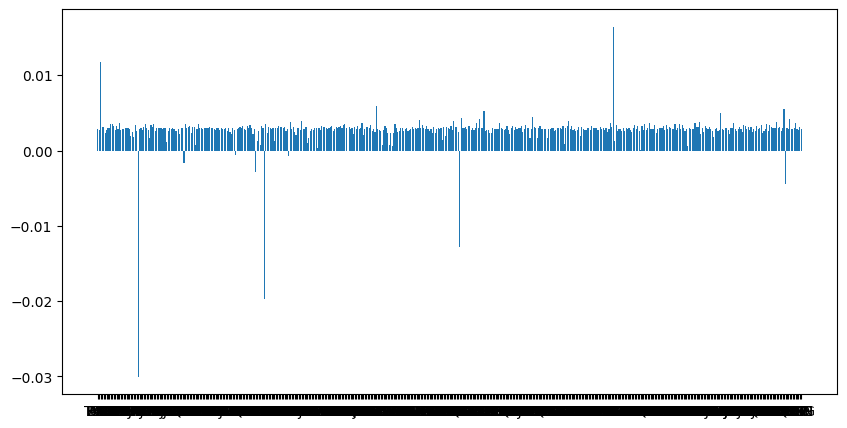

In [594]:
plt.figure(figsize = (10,5))
plt.bar(list(tickers_intersection), weights.detach().numpy())

In [597]:
large_inds = np.where(np.abs(weights.detach().numpy()) > 0.01)[0]

In [598]:
np.array(list(tickers_intersection))[large_inds]

array(['ALL', 'INTC', 'RCL', 'VTR', 'STX'], dtype='<U5')

We will now implement the differentiable Dist-NN algorithm.

In [747]:
year = 2023
quarters = [1,2,3,4]
ticker = 'AAPL'

quantile_funcs = dict()
quantile_means = dict()
dist_dict = dict()
tickers_used_list = []
for quarter in quarters:
    actual_eps, actual_date, actual_time = quarterly_actual[ticker, year, quarter]
    actual_datetime = pd.to_datetime(actual_date + ' ' + actual_time, format = '%Y-%m-%d %H:%M:%S')
    tickers_used = set()
    data = quarterly_data[ticker, year, quarter]
    mean = data['value'].mean()
    quantile_func = empirical_quantile_function(torch.tensor(data['value'].sort_values().values).float())
    for oftic,_ in ibes_tickers:
        data = quarterly_data[oftic, year, quarter]
        if data is None:
            continue
        data = data[data['ann_datetime'] < actual_datetime]
        if len(data) == 0:
            continue
        mean = data['value'].mean()
        quantile_means[oftic, year, quarter] = torch.tensor([mean])
        quantile_funcs[oftic, year, quarter] = empirical_quantile_function(torch.tensor(data['value'].sort_values().values).float())
        dist_dict[oftic, year, quarter] = squared_difference_integral(quantile_func, quantile_funcs[oftic, year, quarter])
        tickers_used.add(oftic)
    tickers_used_list.append(tickers_used)

tickers_intersection = set.intersection(*tickers_used_list)

delete_keys = []
for key in quantile_funcs:
    if key[0] not in tickers_intersection:
        delete_keys.append(key)
for key in delete_keys:
    del quantile_funcs[key]
    del dist_dict[key]
    del quantile_means[key]

In [603]:
distance_threshold = torch.tensor([1.0]).requires_grad_(True)

# Optimize distance threshold
optimizer = optim.Adam([distance_threshold], lr = 0.1)

l1_hyper = 0
# l2_hyper = 10.0
with tqdm(range(200)) as tepoch:
    for i in tepoch:
        optimizer.zero_grad()
        loss = torch.tensor(0.0)
        for quarter in [1,2,3]: # leave out Q4
            quantile_func_quarter = [quantile_funcs[oftic,year,quarter] for oftic in tickers_intersection]
            dist_dict_quarter = [dist_dict[oftic,year,quarter] for oftic in tickers_intersection]
            barycenter_fn = barycenter_threshold(quantile_func_quarter, distance_threshold, dist_dict_quarter)
            mean = expectation(barycenter_fn)
            l1_loss = l1_hyper * torch.norm(weights, p = 1)
            # l2_loss = l2_hyper * (weights @ weights)
            loss += ((mean - actual_eps) ** 2) + l1_loss
        # loss = (torch.abs((mean - actual_eps)) / actual_eps)
        # loss = (mean - actual_eps) ** 2
        loss.backward()
        optimizer.step()
        
        tepoch.set_postfix(loss=loss.item())

100%|██████████| 200/200 [00:08<00:00, 22.49it/s, loss=0.25]


In [605]:
with torch.no_grad():
    for quarter in quarters:
        quantile_func_quarter = [quantile_funcs[oftic,year,quarter] for oftic in tickers_intersection]
        dist_dict_quarter = [dist_dict[oftic,year,quarter] for oftic in tickers_intersection]
        barycenter_fn = barycenter_threshold(quantile_func_quarter, distance_threshold, dist_dict_quarter)
        mean = expectation(barycenter_fn)
        print(f'Quarter {quarter}')
        print(f'Actual EPS:   {actual_eps}')
        print(f'DistNN EPS:   {mean}')
        baseline_eps = quarterly_data[ticker, year, quarter]["value"].mean()
        print(f'Baseline EPS: {baseline_eps}')
        print(f'DistNN Relative Error:   {np.abs(mean - actual_eps) / actual_eps}')
        print(f'Baseline Relative Error: {np.abs(baseline_eps - actual_eps) / actual_eps}')
        print()

Quarter 1
Actual EPS:   1.46
DistNN EPS:   1.710982084274292
Baseline EPS: 1.9916607142857143
DistNN Relative Error:   0.1719055026769638
Baseline Relative Error: 0.3641511741682975

Quarter 2
Actual EPS:   1.46
DistNN EPS:   1.2676317691802979
Baseline EPS: 1.430366666666667
DistNN Relative Error:   0.13175909221172333
Baseline Relative Error: 0.02029680365296778

Quarter 3
Actual EPS:   1.46
DistNN EPS:   1.0724635124206543
Baseline EPS: 1.1925142857142856
DistNN Relative Error:   0.26543596386909485
Baseline Relative Error: 0.18320939334637967

Quarter 4
Actual EPS:   1.46
DistNN EPS:   1.2612287998199463
Baseline EPS: 1.3881142857142859
DistNN Relative Error:   0.13614468276500702
Baseline Relative Error: 0.0492367906066535



/var/folders/zc/6nw_r5b13ws3wfcpdxz6bzcw0000gn/T/ipykernel_14816/1805892018.py:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  print(f'DistNN Relative Error:   {np.abs(mean - actual_eps) / actual_eps}')


As expected, the thresholding operation is not differentiable. We will have to go with the Sigmoid approximation for the thresholding operation.

In [756]:
distance_threshold = torch.tensor([1.0]).requires_grad_(True)
actual_eps, _, _ = quarterly_actual[ticker, year, quarter]
actual_eps = torch.tensor([actual_eps])

# Optimize distance threshold
optimizer = optim.Adam([distance_threshold], lr = 1.0)

with tqdm(range(400)) as tepoch:
    for i in tepoch:
        optimizer.zero_grad()
        loss = torch.tensor(0.0).reshape(1)
        for quarter in [2,3]: # leave out Q4
            # Average distances
            avg_dists = dict()
            for oftic in tickers_intersection:
                for j in range(1,quarter + 1):
                    if oftic not in avg_dists:
                        avg_dists[oftic] = 0
                    avg_dists[oftic] += dist_dict[oftic,year,j]
                avg_dists[oftic] /= quarter - 1
            # Compute the barycenter
            quantile_func_quarter = [quantile_funcs[oftic,year,quarter] for oftic in tickers_intersection]
            dist_dict_quarter = torch.cat([avg_dists[oftic].reshape(1) for oftic in tickers_intersection])
            barycenter_fn = barycenter_threshold_soft(quantile_func_quarter, 
                                                    distance_threshold, 
                                                    dist_dict_quarter,
                                                    sharpness = 2)
            mean = expectation(barycenter_fn) # + quantile_means[ticker, year, quarter]
            loss += (mean - actual_eps) ** 2
        # loss = (torch.abs((mean - actual_eps)) / actual_eps)
        # loss = (mean - actual_eps) ** 2
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            distance_threshold.clamp_(min = 0.0)
        
        tepoch.set_postfix(loss=loss.item(), eta = distance_threshold.item())

100%|██████████| 400/400 [00:21<00:00, 18.18it/s, eta=0.235, loss=0.00955]


In [757]:
with torch.no_grad():
    print(f'Eta: {distance_threshold.item()}')
    for quarter in [2,3,4]:
        quantile_func_quarter = [quantile_funcs[oftic,year,quarter] for oftic in tickers_intersection]
        # Average distances
        avg_dists = dict()
        for oftic in tickers_intersection:
            for j in range(1,quarter + 1):
                if oftic not in avg_dists:
                    avg_dists[oftic] = 0
                avg_dists[oftic] += dist_dict[oftic,year,j]
            avg_dists[oftic] /= quarter - 1
        # Compute the barycenter
        quantile_func_quarter = [quantile_funcs[oftic,year,quarter] for oftic in tickers_intersection]
        dist_dict_quarter = torch.cat([avg_dists[oftic].reshape(1) for oftic in tickers_intersection])
        
        barycenter_fn = barycenter_threshold(quantile_func_quarter, distance_threshold, dist_dict_quarter) # Use hard threshold
        mean = expectation(barycenter_fn) # + torch.tensor(quantile_means[ticker, year, quarter])
        print(f'Quarter {quarter}')
        print(f'Actual EPS:   {actual_eps.item()}')
        print(f'DistNN EPS:   {mean.item()}')
        baseline_eps = quarterly_data[ticker, year, quarter]["value"].mean()
        print(f'Baseline EPS: {baseline_eps.item()}')
        print(f'DistNN Relative Error:   {(np.abs(mean - actual_eps) / actual_eps).item()}')
        print(f'Baseline Relative Error: {(np.abs(baseline_eps - actual_eps) / actual_eps).item()}')
        print()

Eta: 0.2345086634159088
36
Quarter 2
Actual EPS:   1.46
DistNN EPS:   1.5803914070129395
Baseline EPS: 1.430366666666667
DistNN Relative Error:   0.08245986781708184
Baseline Relative Error: 0.02029680365296778

30
Quarter 3
Actual EPS:   1.46
DistNN EPS:   1.4581787586212158
Baseline EPS: 1.1925142857142856
DistNN Relative Error:   0.001247425601906948
Baseline Relative Error: 0.18320939334637967

46
Quarter 4
Actual EPS:   1.46
DistNN EPS:   1.478105902671814
Baseline EPS: 1.3881142857142859
DistNN Relative Error:   0.012401303199872604
Baseline Relative Error: 0.0492367906066535



/var/folders/zc/6nw_r5b13ws3wfcpdxz6bzcw0000gn/T/ipykernel_14816/3378692418.py:24: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  print(f'DistNN Relative Error:   {(np.abs(mean - actual_eps) / actual_eps).item()}')
/var/folders/zc/6nw_r5b13ws3wfcpdxz6bzcw0000gn/T/ipykernel_14816/3378692418.py:25: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  print(f'Baseline Relative Error: {(np.abs(baseline_eps - actual_eps) / actual_eps).item()}')
